In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

c:\Users\CSTra\anaconda3\envs\MLBasic\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Config
RANDOM_STATE = 42

In [3]:
data_root = './data'

train_sales_df = pd.read_parquet(data_root + '/sales_train.parquet', engine='pyarrow')
calendar_df = pd.read_csv(data_root + '/calendar.csv')
inventory_df = pd.read_csv(data_root + '/inventory.csv')

weights_df = pd.read_csv(data_root + '/test_weights.csv')
test_df = pd.read_csv(data_root + '/sales_test.csv')
print(train_sales_df.shape, calendar_df.shape, inventory_df.shape, test_df.shape)

(4007419, 14) (23016, 7) (5432, 8) (47021, 12)


In [4]:
train_sales_df.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0


In [5]:
calendar_df.head()

,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2022-03-16,NaN,0,0,0,0,Frankfurt_1
1,2020-03-22,NaN,0,0,0,0,Frankfurt_1
2,2018-02-07,NaN,0,0,0,0,Frankfurt_1
3,2018-08-10,NaN,0,0,0,0,Frankfurt_1
4,2017-10-26,NaN,0,0,0,0,Prague_2


In [6]:
inventory_df.head()

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


In [7]:
test_df.head()

,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,1226,2024-06-03,Brno_1,8679.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,1226,2024-06-11,Brno_1,8795.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0
2,1226,2024-06-13,Brno_1,10009.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0
3,1226,2024-06-15,Brno_1,8482.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0
4,1226,2024-06-09,Brno_1,8195.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
test_df['unique_id'].nunique()

3625

### 1. EDA


* Check nan values

In [9]:
train_sales_df.isna().mean()

unique_id          0.000000
date               0.000000
warehouse          0.000000
total_orders       0.000013
sales              0.000013
sell_price_main    0.000000
availability       0.000000
type_0_discount    0.000000
type_1_discount    0.000000
type_2_discount    0.000000
type_3_discount    0.000000
type_4_discount    0.000000
type_5_discount    0.000000
type_6_discount    0.000000
dtype: float64

* The missing ratio is low so just remove it

* Check date distribute

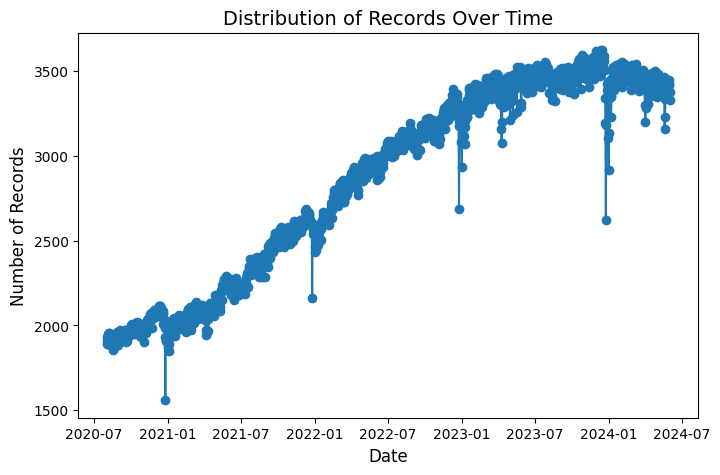

In [10]:
train_sales_df['date'] = pd.to_datetime(train_sales_df['date'])

# Count occurrences of each date
date_counts = train_sales_df['date'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(8, 5))
plt.plot(date_counts.index, date_counts.values, marker='o', linestyle='-')
plt.title('Distribution of Records Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.show()

* Warehouse distribute

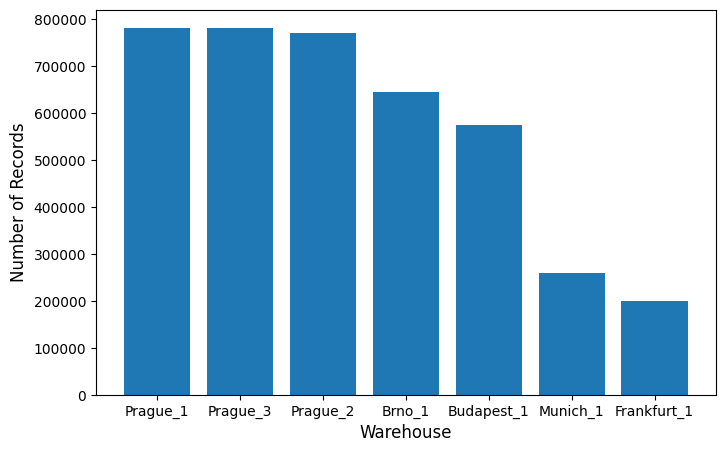

In [11]:
# Count occurrences of each date
wh_count = train_sales_df['warehouse'].value_counts()

# Plotting the distribution
plt.figure(figsize=(8, 5))
plt.bar(wh_count.index, wh_count.values)
plt.xlabel('Warehouse', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.show()

* Availability distribute

<Axes: xlabel='availability', ylabel='Count'>

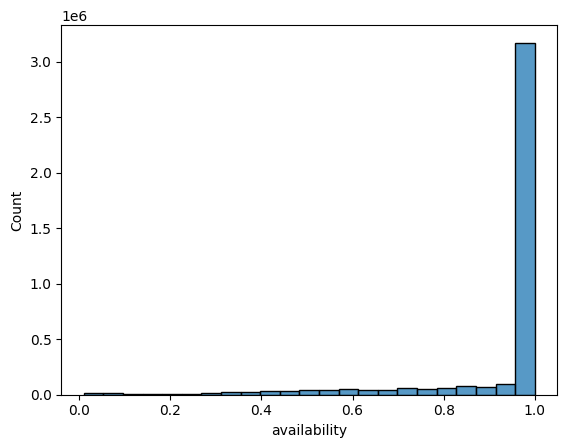

In [12]:
sns.histplot(train_sales_df['availability'])

* EDA calendar

In [13]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
calendar_df = calendar_df.sort_values(by='date')
calendar_df.head()

,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
7260,2016-01-01,New Years Day,1,1,0,0,Prague_2
9914,2016-01-01,New Years Day,1,1,0,0,Budapest_1
22413,2016-01-01,New Years Day,1,1,0,0,Munich_1
22407,2016-01-01,New Years Day,1,1,0,0,Prague_1
9911,2016-01-01,New Years Day,1,1,0,0,Frankfurt_1


In [14]:
# Nums holiday_name
holiday_counts = calendar_df[(calendar_df['date'] > '2016') & (calendar_df['date'] < '2017')]['holiday_name'].value_counts()
holiday_counts

holiday_name
2nd Christmas Day                                              7
1st Christmas Day                                              7
International womens day                                       7
Christmas Eve                                                  7
Labour Day                                                     7
Jan Hus                                                        4
Den boje za svobodu a demokracii                               4
Den vzniku samostatneho ceskoslovenskeho statu                 4
Den ceske statnosti                                            4
Cyrila a Metodej                                               4
Den osvobozeni                                                 4
Whit monday                                                    3
Whit sunday                                                    3
German Unity Day                                               2
Memorial Day for the Victims of the Holocaust                  2
Ascension da

* EDA inventory

In [20]:
print(inventory_df.shape)
inventory_df.head()

(5432, 8)


,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


In [22]:
inventory_df['L1_category_name_en'].value_counts()

L1_category_name_en
Fruit and vegetable    3282
Bakery                 1616
Meat and fish           534
Name: count, dtype: int64

In [21]:
# Nums unique_id and product_unique_id
inventory_df['unique_id'].nunique(), inventory_df['product_unique_id'].nunique()

(5432, 2670)

In [18]:
dup_unique_id = inventory_df[inventory_df.duplicated(subset='product_unique_id', keep=False)]
dup_unique_id.head()

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


In [19]:
dup_unique_id[dup_unique_id['product_unique_id'] == 260]

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
2452,500,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_2
4885,499,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_3
5313,502,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Brno_1


* Seem unique_id indicate for specific warehouse and same product_id

In [20]:
# Check product id
cols = ['product_unique_id', 'name', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en']
inventory_df.drop_duplicates(subset=cols, keep='first').shape[0] == inventory_df['product_unique_id'].nunique()

True

### 2. Data Processing

* 1. Dealing with missing values

In [21]:
# Because missing ratio is very low so just drop missing values
print('Shape before ', train_sales_df.shape)
train_sales_df = train_sales_df.dropna()
print('Shape after ' ,train_sales_df.shape)

Shape before  (4007419, 14)
Shape after  (4007367, 14)


In [22]:
train_sales_df.isna().sum().sum()

0

In [24]:
def data_processing(sales_df, calendar_df, inventory_df):
    sales_df['date'] = pd.to_datetime(sales_df['date'])
    # Mapping holidays infor
    df = pd.merge(sales_df, calendar_df, on=['date', 'warehouse'], how='left')

    # Mapping product_infor
    df = pd.merge(df, inventory_df, on=['unique_id', 'warehouse'], how='left')

    # Convert NaN values in holiday_name to empty string
    df['holiday_name'] = df['holiday_name'].fillna('')
    
    # Create year, month, date cols
    df['year'] = df['date'].dt.year
    df['quater'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['month_name'] = df['date'].dt.month_name()
    df['day_of_week'] = df['date'].dt.day_name()
    df['week'] = df['date'].dt.isocalendar().week
    df['year_sin']  = np.sin(2*np.pi*df['year'])
    df['year_cos'] = np.cos(2*np.pi*df['year'])

    df['month_sin']  = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)

    df['day_sin']  = np.sin(2*np.pi*df['day']/31)
    df['day_cos'] = np.cos(2*np.pi*df['day']/31)
    df['group'] = (df['year'] - 2020)*48 + df['month']*4 + df['day']//7

    # Drop some cols not use for prediction
    if 'availability' in df.columns:
        df = df.drop(columns=['date', 'availability'], axis=1)
    else:
        df = df.drop(columns=['date'], axis=1)

    
    # Convert category datatype
    cate_cols = ['warehouse', 'name', 'holiday_name', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en', 'month_name', 'day_of_week']
    df[cate_cols] = df[cate_cols].astype('category')

    return df

### 3. Training

In [25]:
cate_cols = ['warehouse', 'name', 'holiday_name', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en', 'month_name', 'day_of_week']

* Using cross-validation for time series to evaluate while training

* Since the test set involves predicting approximately 2 weeks, we will take the last 2 weeks from train_sales_df as the validation set.
* Then, we will continuously shift the evaluation and training periods backward by 2 weeks, repeating this process k times.

In [28]:
def get_unique_id_weights(ids, weights_df):
    """ Get coressponding weight for ids """
    weight_map = dict(zip(weights_df['unique_id'], weights_df['weight']))

    # Get coressponding weights
    weights = [weight_map[uid] for uid in ids]
    weights = np.array(weights)

    return weights

In [82]:
def custom_eval_with_weights(y_pred, y_actual, weights):
    """ Calculate WMAE """
    absolute_errors = abs(y_pred - y_actual)
    weighted_absolute_errors = absolute_errors * weights
    wmae = weighted_absolute_errors.sum() / sum(weights)
    
    return wmae  

# Model hyperparams
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 31,  
    'min_data_in_leaf': 25,  
    'seed': 42
}

# Training config
num_epochs = 500
early_stopping_rounds = 3

In [83]:
k_steps = 5
all_data = train_sales_df.copy()
train_losses = []
val_losses = []
for i in range(k_steps):
    print(f"=========== Fold {i+1} ============")

    best_val_loss = float('inf')
    stopping_counter = 0
    train_losses_fold = []
    val_losses_fold = []
    
    # Split train_test
    time_split = all_data['date'].max() - pd.Timedelta(weeks=2)
    train_org_df = all_data[all_data['date'] < time_split]
    val_org_df = all_data[all_data['date'] >= time_split]

    print(f"=== Train size: {len(train_org_df)} - Valid size: {len(val_org_df)} - Time split: {time_split}")
    # Data processing
    train_df = data_processing(train_org_df, calendar_df, inventory_df)
    val_df = data_processing(val_org_df, calendar_df, inventory_df)

    # Create X, y
    X_train, y_train = train_df.drop(columns=['sales']), train_df['sales']
    X_val, y_val = val_df.drop(columns=['sales']), val_df['sales']

    # Get coressponding weight to evaluate model correctly
    train_unique_ids = X_train['unique_id'].values
    train_weights = get_unique_id_weights(train_unique_ids, weights_df)

    val_unique_ids = X_val['unique_id'].values
    val_weights = get_unique_id_weights(val_unique_ids, weights_df)

    # Prepare dataset
    train_set = lgb.Dataset(X_train, label=y_train, categorical_feature=cate_cols)
    val_set = lgb.Dataset(X_val, label=y_val, reference=train_set)

    # Initial model
    model = lgb.Booster(params, train_set)

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        # Huấn luyện một vòng
        model.update(train_set)  # Update model

        # Calculate WMAE
        if epoch % 10 == 0:
            y_val_preds = model.predict(X_val, num_iteration=model.current_iteration())
            y_train_preds = model.predict(X_train, num_iteration=model.current_iteration())

            val_loss = custom_eval_with_weights(y_val, y_val_preds, val_weights)
            train_loss = custom_eval_with_weights(y_train, y_train_preds, train_weights)

            train_losses_fold.append(train_loss)
            val_losses_fold.append(val_loss)

            print(f"Epoch {epoch + 1}, Train loss: {train_loss:.4f} ,Validation loss: {val_loss:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                stopping_counter = 0  # Reset counter loss are decrease
            else:
                stopping_counter += 1

            if stopping_counter >= early_stopping_rounds:
                y_val_preds = model.predict(X_val, num_iteration=model.current_iteration())
                val_loss = custom_eval_with_weights(y_val, y_val_preds, val_weights)
                print(f"==== Train fold {i+1} end with final score: {val_loss}")
                print(f"Early stopping at epoch {epoch + 1}")

                # Save model
                model.save_model(f"save_models/model_{i+1}.txt", num_iteration=model.best_iteration)

                # Add losses_fold to losses
                train_losses.append(train_losses_fold)
                val_losses.append(val_losses_fold)
                break
    
    y_val_preds = model.predict(X_val, num_iteration=model.current_iteration())
    val_loss = custom_eval_with_weights(y_val, y_val_preds, val_weights)
    print(f"==== Train fold {i+1} end with final score: {val_loss}")

    # Save best model
    # Save model
    model.save_model(f"save_models/model_{i+1}.txt", num_iteration=model.best_iteration)
    # Add losses_fold to losses
    train_losses.append(train_losses_fold)
    val_losses.append(val_losses_fold)

    # Update with all data = train_org_data
    all_data = train_org_df

=========== Fold 1 ============
=== Train size: 3956889 - Valid size: 50478 - Time split: 2024-05-19 00:00:00
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5025
[LightGBM] [Info] Number of data points in the train set: 3956889, number of used features: 35


  0%|          | 0/500 [00:00<?, ?it/s]

[LightGBM] [Info] Start training from score 108.310654


  1%|          | 4/500 [00:01<01:51,  4.44it/s]

Epoch 1, Train loss: 76.7545 ,Validation loss: 78.3607


  3%|▎         | 16/500 [00:02<01:11,  6.79it/s]

Epoch 11, Train loss: 40.4786 ,Validation loss: 42.2951


  5%|▌         | 25/500 [00:04<01:20,  5.88it/s]

Epoch 21, Train loss: 31.4596 ,Validation loss: 34.3799


  7%|▋         | 35/500 [00:06<01:28,  5.27it/s]

Epoch 31, Train loss: 28.1794 ,Validation loss: 31.5107


  9%|▉         | 44/500 [00:08<01:31,  4.98it/s]

Epoch 41, Train loss: 25.4242 ,Validation loss: 29.1496


 11%|█         | 56/500 [00:10<01:26,  5.13it/s]

Epoch 51, Train loss: 24.1807 ,Validation loss: 28.1479


 13%|█▎        | 66/500 [00:12<01:30,  4.81it/s]

Epoch 61, Train loss: 23.1170 ,Validation loss: 27.3924


 15%|█▍        | 73/500 [00:14<02:03,  3.44it/s]

Epoch 71, Train loss: 22.6126 ,Validation loss: 26.9078


 17%|█▋        | 85/500 [00:17<01:32,  4.47it/s]

Epoch 81, Train loss: 22.2220 ,Validation loss: 26.6358


 19%|█▉        | 95/500 [00:19<01:37,  4.14it/s]

Epoch 91, Train loss: 21.8617 ,Validation loss: 26.3768


 21%|██        | 106/500 [00:22<01:31,  4.30it/s]

Epoch 101, Train loss: 21.6050 ,Validation loss: 26.1556


 23%|██▎       | 113/500 [00:24<02:09,  2.98it/s]

Epoch 111, Train loss: 21.4268 ,Validation loss: 26.0500


 25%|██▌       | 126/500 [00:27<01:42,  3.66it/s]

Epoch 121, Train loss: 21.1323 ,Validation loss: 25.7590


 27%|██▋       | 137/500 [00:30<01:33,  3.87it/s]

Epoch 131, Train loss: 20.9506 ,Validation loss: 25.5573


 29%|██▉       | 145/500 [00:33<01:41,  3.50it/s]

Epoch 141, Train loss: 20.7777 ,Validation loss: 25.2541


 31%|███       | 156/500 [00:36<01:35,  3.62it/s]

Epoch 151, Train loss: 20.5710 ,Validation loss: 25.0562


 33%|███▎      | 167/500 [00:39<01:32,  3.61it/s]

Epoch 161, Train loss: 20.4113 ,Validation loss: 24.9790


 35%|███▌      | 177/500 [00:43<01:35,  3.37it/s]

Epoch 171, Train loss: 20.2834 ,Validation loss: 24.8672


 37%|███▋      | 185/500 [00:46<01:42,  3.06it/s]

Epoch 181, Train loss: 20.1036 ,Validation loss: 24.2804


 39%|███▉      | 196/500 [00:50<01:34,  3.20it/s]

Epoch 191, Train loss: 20.0172 ,Validation loss: 24.1830


 41%|████      | 206/500 [00:53<01:35,  3.07it/s]

Epoch 201, Train loss: 19.8782 ,Validation loss: 24.0383


 43%|████▎     | 217/500 [00:57<01:31,  3.08it/s]

Epoch 211, Train loss: 19.7295 ,Validation loss: 23.9055


 46%|████▌     | 228/500 [01:01<01:25,  3.18it/s]

Epoch 221, Train loss: 19.6173 ,Validation loss: 23.8399


 47%|████▋     | 235/500 [01:04<01:38,  2.69it/s]

Epoch 231, Train loss: 19.5488 ,Validation loss: 23.8007


 49%|████▉     | 247/500 [01:08<01:23,  3.05it/s]

Epoch 241, Train loss: 19.4706 ,Validation loss: 23.7546


 51%|█████     | 255/500 [01:12<01:31,  2.68it/s]

Epoch 251, Train loss: 19.3867 ,Validation loss: 23.6039


 53%|█████▎    | 265/500 [01:16<01:33,  2.53it/s]

Epoch 261, Train loss: 19.2365 ,Validation loss: 23.5036


 55%|█████▌    | 276/500 [01:21<01:21,  2.74it/s]

Epoch 271, Train loss: 19.1715 ,Validation loss: 23.4542


 57%|█████▋    | 285/500 [01:25<01:22,  2.62it/s]

Epoch 281, Train loss: 19.0731 ,Validation loss: 23.3448


 59%|█████▉    | 296/500 [01:29<01:17,  2.62it/s]

Epoch 291, Train loss: 19.0056 ,Validation loss: 23.2846


 61%|██████▏   | 307/500 [01:34<01:14,  2.58it/s]

Epoch 301, Train loss: 18.9207 ,Validation loss: 23.2671


 63%|██████▎   | 315/500 [01:38<01:19,  2.31it/s]

Epoch 311, Train loss: 18.8585 ,Validation loss: 23.1669


 65%|██████▌   | 326/500 [01:43<01:13,  2.37it/s]

Epoch 321, Train loss: 18.7335 ,Validation loss: 23.1805


 68%|██████▊   | 338/500 [01:48<01:07,  2.41it/s]

Epoch 331, Train loss: 18.6435 ,Validation loss: 23.0638


 69%|██████▉   | 345/500 [01:54<01:19,  1.95it/s]

Epoch 341, Train loss: 18.5692 ,Validation loss: 23.0205


 71%|███████   | 356/500 [01:59<01:12,  1.99it/s]

Epoch 351, Train loss: 18.4942 ,Validation loss: 22.9769


 73%|███████▎  | 366/500 [02:05<01:11,  1.87it/s]

Epoch 361, Train loss: 18.3975 ,Validation loss: 22.5823


 75%|███████▌  | 377/500 [02:11<01:03,  1.92it/s]

Epoch 371, Train loss: 18.3260 ,Validation loss: 22.5739


 77%|███████▋  | 385/500 [02:17<01:05,  1.74it/s]

Epoch 381, Train loss: 18.2684 ,Validation loss: 22.5333


 79%|███████▉  | 396/500 [02:24<00:57,  1.80it/s]

Epoch 391, Train loss: 18.2055 ,Validation loss: 22.4969


 81%|████████  | 406/500 [02:30<00:54,  1.73it/s]

Epoch 401, Train loss: 18.0950 ,Validation loss: 22.2662


 83%|████████▎ | 414/500 [02:36<00:54,  1.57it/s]

Epoch 411, Train loss: 18.0582 ,Validation loss: 22.2553


 85%|████████▌ | 426/500 [02:43<00:42,  1.75it/s]

Epoch 421, Train loss: 18.0072 ,Validation loss: 22.1990


 87%|████████▋ | 435/500 [02:50<00:39,  1.66it/s]

Epoch 431, Train loss: 17.9678 ,Validation loss: 22.1746


 89%|████████▉ | 445/500 [02:56<00:34,  1.61it/s]

Epoch 441, Train loss: 17.8637 ,Validation loss: 21.9870


 92%|█████████▏| 458/500 [03:03<00:23,  1.81it/s]

Epoch 451, Train loss: 17.8123 ,Validation loss: 21.9561


 93%|█████████▎| 465/500 [03:10<00:23,  1.48it/s]

Epoch 461, Train loss: 17.7674 ,Validation loss: 21.9102


 96%|█████████▌| 479/500 [03:18<00:11,  1.79it/s]

Epoch 471, Train loss: 17.7433 ,Validation loss: 21.8965


 97%|█████████▋| 486/500 [03:25<00:09,  1.45it/s]

Epoch 481, Train loss: 17.6858 ,Validation loss: 21.7256


 99%|█████████▉| 494/500 [03:33<00:04,  1.33it/s]

Epoch 491, Train loss: 17.6529 ,Validation loss: 21.6076


100%|██████████| 500/500 [03:33<00:00,  2.34it/s]


==== Train fold 1 end with final score: 21.59191740398046
=========== Fold 2 ============
=== Train size: 3905684 - Valid size: 51205 - Time split: 2024-05-04 00:00:00
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5020
[LightGBM] [Info] Number of data points in the train set: 3905684, number of used features: 35


  0%|          | 0/500 [00:00<?, ?it/s]

[LightGBM] [Info] Start training from score 108.180977


  1%|▏         | 7/500 [00:01<00:57,  8.53it/s]

Epoch 1, Train loss: 76.9794 ,Validation loss: 79.6583


  3%|▎         | 16/500 [00:02<01:07,  7.15it/s]

Epoch 11, Train loss: 39.5698 ,Validation loss: 42.8175


  5%|▌         | 25/500 [00:04<01:18,  6.08it/s]

Epoch 21, Train loss: 31.7447 ,Validation loss: 35.2597


  7%|▋         | 37/500 [00:06<01:03,  7.31it/s]

Epoch 31, Train loss: 27.6201 ,Validation loss: 31.6713


  9%|▊         | 43/500 [00:07<01:53,  4.04it/s]

Epoch 41, Train loss: 25.5098 ,Validation loss: 29.9677


 11%|█         | 56/500 [00:10<01:35,  4.63it/s]

Epoch 51, Train loss: 24.0298 ,Validation loss: 28.8588


 13%|█▎        | 66/500 [00:12<01:39,  4.37it/s]

Epoch 61, Train loss: 23.1982 ,Validation loss: 28.0453


 15%|█▌        | 76/500 [00:15<01:38,  4.31it/s]

Epoch 71, Train loss: 22.7418 ,Validation loss: 27.7247


 17%|█▋        | 86/500 [00:17<01:38,  4.20it/s]

Epoch 81, Train loss: 22.2366 ,Validation loss: 27.5397


 19%|█▉        | 97/500 [00:20<01:36,  4.19it/s]

Epoch 91, Train loss: 21.9340 ,Validation loss: 27.1331


 22%|██▏       | 108/500 [00:23<01:31,  4.28it/s]

Epoch 101, Train loss: 21.5087 ,Validation loss: 26.6672


 23%|██▎       | 115/500 [00:26<01:47,  3.57it/s]

Epoch 111, Train loss: 21.3216 ,Validation loss: 26.5807


 25%|██▌       | 126/500 [00:29<01:40,  3.71it/s]

Epoch 121, Train loss: 21.1072 ,Validation loss: 26.4527


 27%|██▋       | 137/500 [00:32<01:38,  3.68it/s]

Epoch 131, Train loss: 20.8842 ,Validation loss: 26.2131


 29%|██▉       | 145/500 [00:35<01:46,  3.33it/s]

Epoch 141, Train loss: 20.7256 ,Validation loss: 26.0807


 31%|███▏      | 157/500 [00:38<01:33,  3.68it/s]

Epoch 151, Train loss: 20.5305 ,Validation loss: 25.6380


 33%|███▎      | 165/500 [00:42<01:44,  3.20it/s]

Epoch 161, Train loss: 20.3214 ,Validation loss: 25.4954


 35%|███▌      | 177/500 [00:45<01:34,  3.41it/s]

Epoch 171, Train loss: 20.2084 ,Validation loss: 25.4137


 38%|███▊      | 190/500 [00:49<01:09,  4.48it/s]

Epoch 181, Train loss: 20.0145 ,Validation loss: 25.2187


 40%|███▉      | 198/500 [00:52<01:28,  3.40it/s]

Epoch 191, Train loss: 19.8513 ,Validation loss: 25.0915


 41%|████      | 206/500 [00:56<01:37,  3.02it/s]

Epoch 201, Train loss: 19.7312 ,Validation loss: 25.0451


 43%|████▎     | 217/500 [01:00<01:35,  2.97it/s]

Epoch 211, Train loss: 19.6222 ,Validation loss: 24.9124


 45%|████▌     | 225/500 [01:04<01:41,  2.71it/s]

Epoch 221, Train loss: 19.5085 ,Validation loss: 24.8311


 48%|████▊     | 239/500 [01:08<01:20,  3.25it/s]

Epoch 231, Train loss: 19.4371 ,Validation loss: 24.7905


 49%|████▉     | 246/500 [01:12<01:36,  2.63it/s]

Epoch 241, Train loss: 19.3471 ,Validation loss: 24.5887


 52%|█████▏    | 258/500 [01:16<01:24,  2.88it/s]

Epoch 251, Train loss: 19.2596 ,Validation loss: 24.5665


 54%|█████▍    | 269/500 [01:20<01:08,  3.37it/s]

Epoch 261, Train loss: 19.1904 ,Validation loss: 24.5247


 55%|█████▌    | 276/500 [01:25<01:30,  2.49it/s]

Epoch 271, Train loss: 19.0687 ,Validation loss: 24.3845


 58%|█████▊    | 288/500 [01:29<01:17,  2.73it/s]

Epoch 281, Train loss: 18.9960 ,Validation loss: 24.3561


 59%|█████▉    | 296/500 [01:34<01:23,  2.44it/s]

Epoch 291, Train loss: 18.9699 ,Validation loss: 24.3398


 61%|██████▏   | 307/500 [01:38<01:19,  2.42it/s]

Epoch 301, Train loss: 18.9301 ,Validation loss: 24.3216


 63%|██████▎   | 315/500 [01:43<01:25,  2.15it/s]

Epoch 311, Train loss: 18.8039 ,Validation loss: 24.2351


 65%|██████▌   | 327/500 [01:49<01:12,  2.39it/s]

Epoch 321, Train loss: 18.7047 ,Validation loss: 24.2315


 67%|██████▋   | 335/500 [01:54<01:21,  2.02it/s]

Epoch 331, Train loss: 18.6464 ,Validation loss: 24.2053


 69%|██████▉   | 346/500 [02:00<01:20,  1.91it/s]

Epoch 341, Train loss: 18.5826 ,Validation loss: 24.0837


 71%|███████   | 356/500 [02:06<01:21,  1.77it/s]

Epoch 351, Train loss: 18.5134 ,Validation loss: 23.9764


 73%|███████▎  | 366/500 [02:12<01:20,  1.67it/s]

Epoch 361, Train loss: 18.4145 ,Validation loss: 23.5183


 75%|███████▌  | 376/500 [02:18<01:10,  1.76it/s]

Epoch 371, Train loss: 18.3476 ,Validation loss: 23.4868


 77%|███████▋  | 387/500 [02:24<00:57,  1.96it/s]

Epoch 381, Train loss: 18.2654 ,Validation loss: 23.4422


 79%|███████▉  | 395/500 [02:30<01:00,  1.73it/s]

Epoch 391, Train loss: 18.2343 ,Validation loss: 23.3317


 81%|████████  | 406/500 [02:37<00:52,  1.77it/s]

Epoch 401, Train loss: 18.1770 ,Validation loss: 22.8223


 83%|████████▎ | 417/500 [02:43<00:46,  1.77it/s]

Epoch 411, Train loss: 18.0575 ,Validation loss: 22.7072


 85%|████████▌ | 425/500 [02:50<00:46,  1.61it/s]

Epoch 421, Train loss: 17.9954 ,Validation loss: 22.6827


 87%|████████▋ | 437/500 [02:56<00:35,  1.77it/s]

Epoch 431, Train loss: 17.9717 ,Validation loss: 22.6706


 89%|████████▉ | 445/500 [03:03<00:34,  1.59it/s]

Epoch 441, Train loss: 17.9215 ,Validation loss: 22.6527


 92%|█████████▏| 458/500 [03:10<00:22,  1.85it/s]

Epoch 451, Train loss: 17.8637 ,Validation loss: 22.6164


 93%|█████████▎| 465/500 [03:17<00:23,  1.52it/s]

Epoch 461, Train loss: 17.8261 ,Validation loss: 22.5706


 95%|█████████▌| 477/500 [03:24<00:13,  1.69it/s]

Epoch 471, Train loss: 17.7761 ,Validation loss: 22.5673


 97%|█████████▋| 486/500 [03:31<00:08,  1.60it/s]

Epoch 481, Train loss: 17.7188 ,Validation loss: 22.5374


 99%|█████████▉| 497/500 [03:39<00:01,  1.56it/s]

Epoch 491, Train loss: 17.6900 ,Validation loss: 22.5446


100%|██████████| 500/500 [03:39<00:00,  2.28it/s]


==== Train fold 2 end with final score: 22.523296733068985
=========== Fold 3 ============
=== Train size: 3854156 - Valid size: 51528 - Time split: 2024-04-19 00:00:00
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5002
[LightGBM] [Info] Number of data points in the train set: 3854156, number of used features: 35


  0%|          | 0/500 [00:00<?, ?it/s]

[LightGBM] [Info] Start training from score 108.056270


  1%|          | 4/500 [00:01<01:46,  4.64it/s]

Epoch 1, Train loss: 76.8992 ,Validation loss: 79.2888


  3%|▎         | 16/500 [00:02<01:08,  7.06it/s]

Epoch 11, Train loss: 40.1071 ,Validation loss: 42.6803


  5%|▌         | 25/500 [00:04<01:18,  6.05it/s]

Epoch 21, Train loss: 31.5696 ,Validation loss: 34.9702


  7%|▋         | 34/500 [00:05<01:24,  5.49it/s]

Epoch 31, Train loss: 28.0730 ,Validation loss: 31.9846


  9%|▉         | 47/500 [00:08<01:15,  6.01it/s]

Epoch 41, Train loss: 25.5917 ,Validation loss: 30.0226


 11%|█▏        | 57/500 [00:10<01:12,  6.14it/s]

Epoch 51, Train loss: 24.1562 ,Validation loss: 28.9373


 13%|█▎        | 66/500 [00:12<01:35,  4.56it/s]

Epoch 61, Train loss: 23.3935 ,Validation loss: 28.3955


 15%|█▌        | 77/500 [00:15<01:32,  4.56it/s]

Epoch 71, Train loss: 22.6992 ,Validation loss: 27.7846


 17%|█▋        | 87/500 [00:17<01:35,  4.34it/s]

Epoch 81, Train loss: 22.1956 ,Validation loss: 27.3706


 19%|█▉        | 97/500 [00:20<01:37,  4.11it/s]

Epoch 91, Train loss: 21.8974 ,Validation loss: 27.1733


 21%|██▏       | 107/500 [00:23<01:39,  3.93it/s]

Epoch 101, Train loss: 21.5913 ,Validation loss: 26.7782


 23%|██▎       | 115/500 [00:25<01:47,  3.59it/s]

Epoch 111, Train loss: 21.2752 ,Validation loss: 26.4880


 25%|██▌       | 126/500 [00:28<01:40,  3.73it/s]

Epoch 121, Train loss: 21.0937 ,Validation loss: 26.3488


 27%|██▋       | 137/500 [00:32<01:38,  3.70it/s]

Epoch 131, Train loss: 20.8424 ,Validation loss: 26.1423


 29%|██▉       | 145/500 [00:35<01:46,  3.33it/s]

Epoch 141, Train loss: 20.6972 ,Validation loss: 26.1078


 31%|███       | 156/500 [00:38<01:41,  3.39it/s]

Epoch 151, Train loss: 20.4334 ,Validation loss: 25.3186


 33%|███▎      | 167/500 [00:41<01:38,  3.37it/s]

Epoch 161, Train loss: 20.2522 ,Validation loss: 25.2458


 35%|███▌      | 175/500 [00:45<01:46,  3.06it/s]

Epoch 171, Train loss: 20.1268 ,Validation loss: 25.1900


 37%|███▋      | 187/500 [00:48<01:32,  3.37it/s]

Epoch 181, Train loss: 19.9837 ,Validation loss: 25.0810


 39%|███▉      | 195/500 [00:52<01:44,  2.93it/s]

Epoch 191, Train loss: 19.8237 ,Validation loss: 24.4958


 41%|████      | 205/500 [00:56<01:43,  2.86it/s]

Epoch 201, Train loss: 19.7060 ,Validation loss: 24.4301


 43%|████▎     | 217/500 [01:00<01:30,  3.14it/s]

Epoch 211, Train loss: 19.5768 ,Validation loss: 24.3674


 46%|████▌     | 229/500 [01:04<01:11,  3.77it/s]

Epoch 221, Train loss: 19.4738 ,Validation loss: 24.1611


 47%|████▋     | 236/500 [01:08<01:35,  2.78it/s]

Epoch 231, Train loss: 19.3750 ,Validation loss: 24.0831


 49%|████▉     | 245/500 [01:12<01:36,  2.65it/s]

Epoch 241, Train loss: 19.2975 ,Validation loss: 24.0211


 51%|█████     | 256/500 [01:16<01:32,  2.63it/s]

Epoch 251, Train loss: 19.1406 ,Validation loss: 23.9424


 53%|█████▎    | 266/500 [01:21<01:33,  2.49it/s]

Epoch 261, Train loss: 19.0336 ,Validation loss: 23.5487


 56%|█████▌    | 278/500 [01:25<01:21,  2.72it/s]

Epoch 271, Train loss: 18.9649 ,Validation loss: 23.4822


 57%|█████▋    | 285/500 [01:30<01:36,  2.23it/s]

Epoch 281, Train loss: 18.8900 ,Validation loss: 23.4807


 59%|█████▉    | 296/500 [01:35<01:27,  2.33it/s]

Epoch 291, Train loss: 18.8026 ,Validation loss: 23.4517


 62%|██████▏   | 308/500 [01:40<01:15,  2.53it/s]

Epoch 301, Train loss: 18.6997 ,Validation loss: 23.3697


 63%|██████▎   | 315/500 [01:45<01:29,  2.07it/s]

Epoch 311, Train loss: 18.6031 ,Validation loss: 23.3157


 65%|██████▌   | 326/500 [01:50<01:20,  2.17it/s]

Epoch 321, Train loss: 18.5386 ,Validation loss: 23.3008


 67%|██████▋   | 337/500 [01:55<01:15,  2.16it/s]

Epoch 331, Train loss: 18.4468 ,Validation loss: 23.2460


 69%|██████▉   | 345/500 [02:01<01:19,  1.95it/s]

Epoch 341, Train loss: 18.3816 ,Validation loss: 23.2099


 71%|███████▏  | 357/500 [02:06<01:08,  2.09it/s]

Epoch 351, Train loss: 18.3002 ,Validation loss: 23.1392


 73%|███████▎  | 365/500 [02:12<01:12,  1.86it/s]

Epoch 361, Train loss: 18.2578 ,Validation loss: 23.1003


 75%|███████▌  | 377/500 [02:18<00:59,  2.06it/s]

Epoch 371, Train loss: 18.1626 ,Validation loss: 22.8249


 77%|███████▋  | 386/500 [02:24<00:59,  1.93it/s]

Epoch 381, Train loss: 18.1034 ,Validation loss: 22.7922


 79%|███████▉  | 396/500 [02:30<00:53,  1.95it/s]

Epoch 391, Train loss: 18.1000 ,Validation loss: 22.7889


 81%|████████  | 405/500 [02:36<00:52,  1.82it/s]

Epoch 401, Train loss: 18.0468 ,Validation loss: 22.7285


 83%|████████▎ | 417/500 [02:43<00:43,  1.92it/s]

Epoch 411, Train loss: 17.9817 ,Validation loss: 22.6656


 85%|████████▌ | 426/500 [02:49<00:41,  1.78it/s]

Epoch 421, Train loss: 17.9197 ,Validation loss: 22.6180


 88%|████████▊ | 438/500 [02:56<00:33,  1.85it/s]

Epoch 431, Train loss: 17.8652 ,Validation loss: 22.5965


 89%|████████▉ | 445/500 [03:03<00:36,  1.50it/s]

Epoch 441, Train loss: 17.8122 ,Validation loss: 22.3904


 92%|█████████▏| 459/500 [03:10<00:22,  1.84it/s]

Epoch 451, Train loss: 17.7615 ,Validation loss: 22.3598


 93%|█████████▎| 467/500 [03:18<00:20,  1.59it/s]

Epoch 461, Train loss: 17.6835 ,Validation loss: 22.3331


 95%|█████████▌| 477/500 [03:25<00:15,  1.50it/s]

Epoch 471, Train loss: 17.5503 ,Validation loss: 22.2696


 97%|█████████▋| 486/500 [03:33<00:09,  1.48it/s]

Epoch 481, Train loss: 17.4899 ,Validation loss: 22.2647


 99%|█████████▉| 495/500 [03:40<00:03,  1.43it/s]

Epoch 491, Train loss: 17.4608 ,Validation loss: 22.2494


100%|██████████| 500/500 [03:40<00:00,  2.26it/s]


==== Train fold 3 end with final score: 22.233835946248476
=========== Fold 4 ============
=== Train size: 3802932 - Valid size: 51224 - Time split: 2024-04-04 00:00:00
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5008
[LightGBM] [Info] Number of data points in the train set: 3802932, number of used features: 35


  0%|          | 0/500 [00:00<?, ?it/s]

[LightGBM] [Info] Start training from score 107.920094


  1%|          | 4/500 [00:01<01:47,  4.61it/s]

Epoch 1, Train loss: 76.7548 ,Validation loss: 76.5317


  3%|▎         | 16/500 [00:02<01:08,  7.02it/s]

Epoch 11, Train loss: 40.1675 ,Validation loss: 41.7912


  5%|▌         | 25/500 [00:04<01:18,  6.04it/s]

Epoch 21, Train loss: 31.7067 ,Validation loss: 33.9193


  7%|▋         | 34/500 [00:06<01:25,  5.45it/s]

Epoch 31, Train loss: 27.7328 ,Validation loss: 32.1215


  9%|▉         | 47/500 [00:08<01:15,  5.97it/s]

Epoch 41, Train loss: 25.4902 ,Validation loss: 30.4968


 11%|█         | 56/500 [00:10<01:32,  4.79it/s]

Epoch 51, Train loss: 24.1086 ,Validation loss: 29.4040


 13%|█▎        | 67/500 [00:12<01:28,  4.88it/s]

Epoch 61, Train loss: 23.1750 ,Validation loss: 28.7993


 15%|█▌        | 76/500 [00:15<01:42,  4.15it/s]

Epoch 71, Train loss: 22.6594 ,Validation loss: 28.4346


 17%|█▋        | 86/500 [00:17<01:44,  3.97it/s]

Epoch 81, Train loss: 22.2161 ,Validation loss: 27.9241


 19%|█▉        | 97/500 [00:20<01:38,  4.10it/s]

Epoch 91, Train loss: 21.7132 ,Validation loss: 27.5192


 21%|██        | 105/500 [00:23<01:45,  3.74it/s]

Epoch 101, Train loss: 21.4464 ,Validation loss: 27.3487


 23%|██▎       | 116/500 [00:26<01:39,  3.85it/s]

Epoch 111, Train loss: 21.1784 ,Validation loss: 27.2240


 25%|██▌       | 125/500 [00:28<01:41,  3.70it/s]

Epoch 121, Train loss: 20.9955 ,Validation loss: 26.8036


 27%|██▋       | 136/500 [00:32<01:38,  3.70it/s]

Epoch 131, Train loss: 20.8231 ,Validation loss: 26.6933


 29%|██▉       | 147/500 [00:35<01:38,  3.59it/s]

Epoch 141, Train loss: 20.6546 ,Validation loss: 26.5845


 31%|███       | 156/500 [00:38<01:57,  2.92it/s]

Epoch 151, Train loss: 20.4140 ,Validation loss: 25.7602


 33%|███▎      | 166/500 [00:42<02:00,  2.78it/s]

Epoch 161, Train loss: 20.2821 ,Validation loss: 25.6831


 36%|███▌      | 178/500 [00:46<01:36,  3.33it/s]

Epoch 171, Train loss: 20.1520 ,Validation loss: 25.6633


 37%|███▋      | 185/500 [00:49<01:51,  2.82it/s]

Epoch 181, Train loss: 20.1009 ,Validation loss: 25.6826


 39%|███▉      | 197/500 [00:53<01:34,  3.21it/s]

Epoch 191, Train loss: 19.9410 ,Validation loss: 25.5260


 41%|████      | 205/500 [00:57<01:42,  2.87it/s]

Epoch 201, Train loss: 19.8819 ,Validation loss: 25.5151


 43%|████▎     | 216/500 [01:01<01:38,  2.89it/s]

Epoch 211, Train loss: 19.7721 ,Validation loss: 25.4349


 45%|████▍     | 224/500 [01:05<01:54,  2.42it/s]

Epoch 221, Train loss: 19.6531 ,Validation loss: 25.3631


 47%|████▋     | 236/500 [01:10<01:54,  2.31it/s]

Epoch 231, Train loss: 19.4746 ,Validation loss: 25.2387


 49%|████▉     | 247/500 [01:15<01:41,  2.49it/s]

Epoch 241, Train loss: 19.2965 ,Validation loss: 25.1305


 51%|█████     | 255/500 [01:19<01:50,  2.21it/s]

Epoch 251, Train loss: 19.1942 ,Validation loss: 24.6950


 53%|█████▎    | 266/500 [01:24<01:41,  2.30it/s]

Epoch 261, Train loss: 19.0545 ,Validation loss: 24.6193


 55%|█████▌    | 276/500 [01:29<01:45,  2.13it/s]

Epoch 271, Train loss: 18.9817 ,Validation loss: 24.5894


 57%|█████▋    | 287/500 [01:34<01:35,  2.24it/s]

Epoch 281, Train loss: 18.9166 ,Validation loss: 24.5730


 59%|█████▉    | 297/500 [01:40<01:35,  2.14it/s]

Epoch 291, Train loss: 18.8474 ,Validation loss: 24.5099


 61%|██████    | 305/500 [01:45<01:36,  2.01it/s]

Epoch 301, Train loss: 18.7875 ,Validation loss: 24.4690


 63%|██████▎   | 317/500 [01:50<01:23,  2.18it/s]

Epoch 311, Train loss: 18.6938 ,Validation loss: 24.3816


 65%|██████▍   | 324/500 [01:55<01:38,  1.79it/s]

Epoch 321, Train loss: 18.5775 ,Validation loss: 24.2879


 67%|██████▋   | 335/500 [02:01<01:25,  1.93it/s]

Epoch 331, Train loss: 18.4764 ,Validation loss: 24.2417


 69%|██████▉   | 346/500 [02:07<01:20,  1.92it/s]

Epoch 341, Train loss: 18.4390 ,Validation loss: 24.2290


 71%|███████   | 356/500 [02:13<01:22,  1.75it/s]

Epoch 351, Train loss: 18.3863 ,Validation loss: 24.2467


 73%|███████▎  | 366/500 [02:20<01:17,  1.72it/s]

Epoch 361, Train loss: 18.2991 ,Validation loss: 24.1828


 75%|███████▌  | 377/500 [02:26<01:12,  1.71it/s]

Epoch 371, Train loss: 18.2600 ,Validation loss: 24.1779


 78%|███████▊  | 388/500 [02:33<01:00,  1.87it/s]

Epoch 381, Train loss: 18.1932 ,Validation loss: 24.1568


 79%|███████▉  | 395/500 [02:39<01:06,  1.59it/s]

Epoch 391, Train loss: 18.0725 ,Validation loss: 24.0775


 81%|████████▏ | 407/500 [02:45<00:50,  1.83it/s]

Epoch 401, Train loss: 17.9844 ,Validation loss: 24.1020


 83%|████████▎ | 415/500 [02:52<00:51,  1.64it/s]

Epoch 411, Train loss: 17.9065 ,Validation loss: 24.0080


 85%|████████▌ | 426/500 [02:58<00:43,  1.69it/s]

Epoch 421, Train loss: 17.8702 ,Validation loss: 23.9174


 87%|████████▋ | 435/500 [03:05<00:40,  1.62it/s]

Epoch 431, Train loss: 17.8374 ,Validation loss: 23.9112


 89%|████████▉ | 446/500 [03:12<00:32,  1.64it/s]

Epoch 441, Train loss: 17.8120 ,Validation loss: 23.9182


 91%|█████████ | 456/500 [03:19<00:28,  1.54it/s]

Epoch 451, Train loss: 17.7492 ,Validation loss: 23.8613


 94%|█████████▎| 468/500 [03:27<00:19,  1.68it/s]

Epoch 461, Train loss: 17.7205 ,Validation loss: 23.8450


 96%|█████████▌| 478/500 [03:34<00:11,  1.85it/s]

Epoch 471, Train loss: 17.6762 ,Validation loss: 23.8155


 97%|█████████▋| 485/500 [03:42<00:10,  1.41it/s]

Epoch 481, Train loss: 17.6245 ,Validation loss: 23.7785


 99%|█████████▉| 496/500 [03:50<00:02,  1.45it/s]

Epoch 491, Train loss: 17.5595 ,Validation loss: 23.6962


100%|██████████| 500/500 [03:50<00:00,  2.17it/s]


==== Train fold 4 end with final score: 23.682416227855903
=========== Fold 5 ============
=== Train size: 3751763 - Valid size: 51169 - Time split: 2024-03-20 00:00:00
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4983
[LightGBM] [Info] Number of data points in the train set: 3751763, number of used features: 35


  0%|          | 0/500 [00:00<?, ?it/s]

[LightGBM] [Info] Start training from score 107.872891


  1%|          | 4/500 [00:01<01:49,  4.53it/s]

Epoch 1, Train loss: 76.3399 ,Validation loss: 75.5084


  3%|▎         | 13/500 [00:02<01:41,  4.81it/s]

Epoch 11, Train loss: 39.1673 ,Validation loss: 40.7272


  5%|▍         | 24/500 [00:04<01:26,  5.49it/s]

Epoch 21, Train loss: 31.5562 ,Validation loss: 34.2576


  7%|▋         | 34/500 [00:06<01:32,  5.04it/s]

Epoch 31, Train loss: 27.6664 ,Validation loss: 31.0292


  9%|▉         | 45/500 [00:08<01:31,  4.98it/s]

Epoch 41, Train loss: 25.1864 ,Validation loss: 29.2657


 11%|█         | 54/500 [00:10<01:45,  4.23it/s]

Epoch 51, Train loss: 23.9315 ,Validation loss: 28.3410


 13%|█▎        | 67/500 [00:13<01:30,  4.76it/s]

Epoch 61, Train loss: 23.1737 ,Validation loss: 27.7015


 15%|█▌        | 76/500 [00:15<01:48,  3.92it/s]

Epoch 71, Train loss: 22.6424 ,Validation loss: 27.4635


 17%|█▋        | 86/500 [00:18<01:45,  3.93it/s]

Epoch 81, Train loss: 22.1448 ,Validation loss: 26.8242


 19%|█▉        | 97/500 [00:21<01:40,  4.02it/s]

Epoch 91, Train loss: 21.7892 ,Validation loss: 26.5695


 21%|██▏       | 107/500 [00:24<01:42,  3.82it/s]

Epoch 101, Train loss: 21.5046 ,Validation loss: 26.4327


 23%|██▎       | 117/500 [00:27<01:47,  3.56it/s]

Epoch 111, Train loss: 21.2934 ,Validation loss: 26.2039


 25%|██▍       | 124/500 [00:30<02:03,  3.04it/s]

Epoch 121, Train loss: 21.0531 ,Validation loss: 25.4492


 27%|██▋       | 136/500 [00:33<01:39,  3.67it/s]

Epoch 131, Train loss: 20.8684 ,Validation loss: 25.3895


 29%|██▉       | 147/500 [00:37<01:40,  3.52it/s]

Epoch 141, Train loss: 20.7159 ,Validation loss: 25.3512


 31%|███       | 155/500 [00:40<01:50,  3.13it/s]

Epoch 151, Train loss: 20.4962 ,Validation loss: 24.6634


 33%|███▎      | 166/500 [00:43<01:41,  3.29it/s]

Epoch 161, Train loss: 20.3312 ,Validation loss: 24.5623


 35%|███▌      | 177/500 [00:47<01:40,  3.23it/s]

Epoch 171, Train loss: 20.1722 ,Validation loss: 24.4595


 37%|███▋      | 185/500 [00:51<01:49,  2.87it/s]

Epoch 181, Train loss: 19.9748 ,Validation loss: 24.3578


 39%|███▉      | 197/500 [00:54<01:38,  3.08it/s]

Epoch 191, Train loss: 19.8875 ,Validation loss: 24.1301


 41%|████      | 205/500 [00:58<01:48,  2.72it/s]

Epoch 201, Train loss: 19.7122 ,Validation loss: 24.0536


 43%|████▎     | 216/500 [01:03<01:43,  2.75it/s]

Epoch 211, Train loss: 19.6320 ,Validation loss: 24.0018


 45%|████▌     | 226/500 [01:07<01:43,  2.66it/s]

Epoch 221, Train loss: 19.4823 ,Validation loss: 23.8965


 47%|████▋     | 237/500 [01:11<01:33,  2.82it/s]

Epoch 231, Train loss: 19.3412 ,Validation loss: 23.5224


 49%|████▉     | 244/500 [01:15<01:48,  2.35it/s]

Epoch 241, Train loss: 19.2847 ,Validation loss: 23.5070


 51%|█████     | 255/500 [01:19<01:37,  2.50it/s]

Epoch 251, Train loss: 19.1686 ,Validation loss: 23.5269


 53%|█████▎    | 266/500 [01:24<01:31,  2.55it/s]

Epoch 261, Train loss: 19.0982 ,Validation loss: 23.4731


 55%|█████▌    | 277/500 [01:28<01:28,  2.52it/s]

Epoch 271, Train loss: 19.0127 ,Validation loss: 23.4400


 57%|█████▋    | 286/500 [01:33<01:28,  2.43it/s]

Epoch 281, Train loss: 18.9658 ,Validation loss: 23.4202


 60%|█████▉    | 298/500 [01:38<01:18,  2.56it/s]

Epoch 291, Train loss: 18.8609 ,Validation loss: 23.3683


 61%|██████    | 306/500 [01:43<01:24,  2.29it/s]

Epoch 301, Train loss: 18.7993 ,Validation loss: 23.3098


 63%|██████▎   | 315/500 [01:48<01:22,  2.23it/s]

Epoch 311, Train loss: 18.7516 ,Validation loss: 23.3632


 65%|██████▌   | 325/500 [01:53<01:21,  2.14it/s]

Epoch 321, Train loss: 18.7037 ,Validation loss: 23.3279


 67%|██████▋   | 337/500 [01:58<01:12,  2.26it/s]

Epoch 331, Train loss: 18.6323 ,Validation loss: 23.2704


 69%|██████▉   | 345/500 [02:04<01:18,  1.98it/s]

Epoch 341, Train loss: 18.5395 ,Validation loss: 23.2232


 71%|███████   | 356/500 [02:09<01:10,  2.03it/s]

Epoch 351, Train loss: 18.4105 ,Validation loss: 23.1772


 73%|███████▎  | 367/500 [02:15<01:06,  2.01it/s]

Epoch 361, Train loss: 18.3350 ,Validation loss: 23.1393


 75%|███████▌  | 375/500 [02:21<01:08,  1.82it/s]

Epoch 371, Train loss: 18.2675 ,Validation loss: 23.1051


 77%|███████▋  | 385/500 [02:27<01:03,  1.82it/s]

Epoch 381, Train loss: 18.1297 ,Validation loss: 23.0583


 79%|███████▉  | 397/500 [02:33<00:53,  1.91it/s]

Epoch 391, Train loss: 18.0705 ,Validation loss: 23.0892


 81%|████████  | 405/500 [02:39<00:55,  1.72it/s]

Epoch 401, Train loss: 17.9709 ,Validation loss: 23.0144


 83%|████████▎ | 416/500 [02:45<00:47,  1.76it/s]

Epoch 411, Train loss: 17.9107 ,Validation loss: 22.9813


 86%|████████▌ | 428/500 [02:52<00:38,  1.89it/s]

Epoch 421, Train loss: 17.7969 ,Validation loss: 22.8861


 87%|████████▋ | 435/500 [02:58<00:41,  1.58it/s]

Epoch 431, Train loss: 17.7553 ,Validation loss: 22.8405


 90%|████████▉ | 448/500 [03:05<00:28,  1.85it/s]

Epoch 441, Train loss: 17.7128 ,Validation loss: 22.8161


 91%|█████████ | 455/500 [03:12<00:29,  1.52it/s]

Epoch 451, Train loss: 17.6509 ,Validation loss: 22.7695


 94%|█████████▎| 468/500 [03:19<00:18,  1.74it/s]

Epoch 461, Train loss: 17.6200 ,Validation loss: 22.7436


 95%|█████████▌| 476/500 [03:26<00:15,  1.55it/s]

Epoch 471, Train loss: 17.5515 ,Validation loss: 22.6917


 97%|█████████▋| 486/500 [03:34<00:09,  1.50it/s]

Epoch 481, Train loss: 17.5181 ,Validation loss: 22.6872


 99%|█████████▉| 495/500 [03:42<00:03,  1.47it/s]

Epoch 491, Train loss: 17.4909 ,Validation loss: 22.6730


100%|██████████| 500/500 [03:42<00:00,  2.25it/s]


==== Train fold 5 end with final score: 22.65724585208989


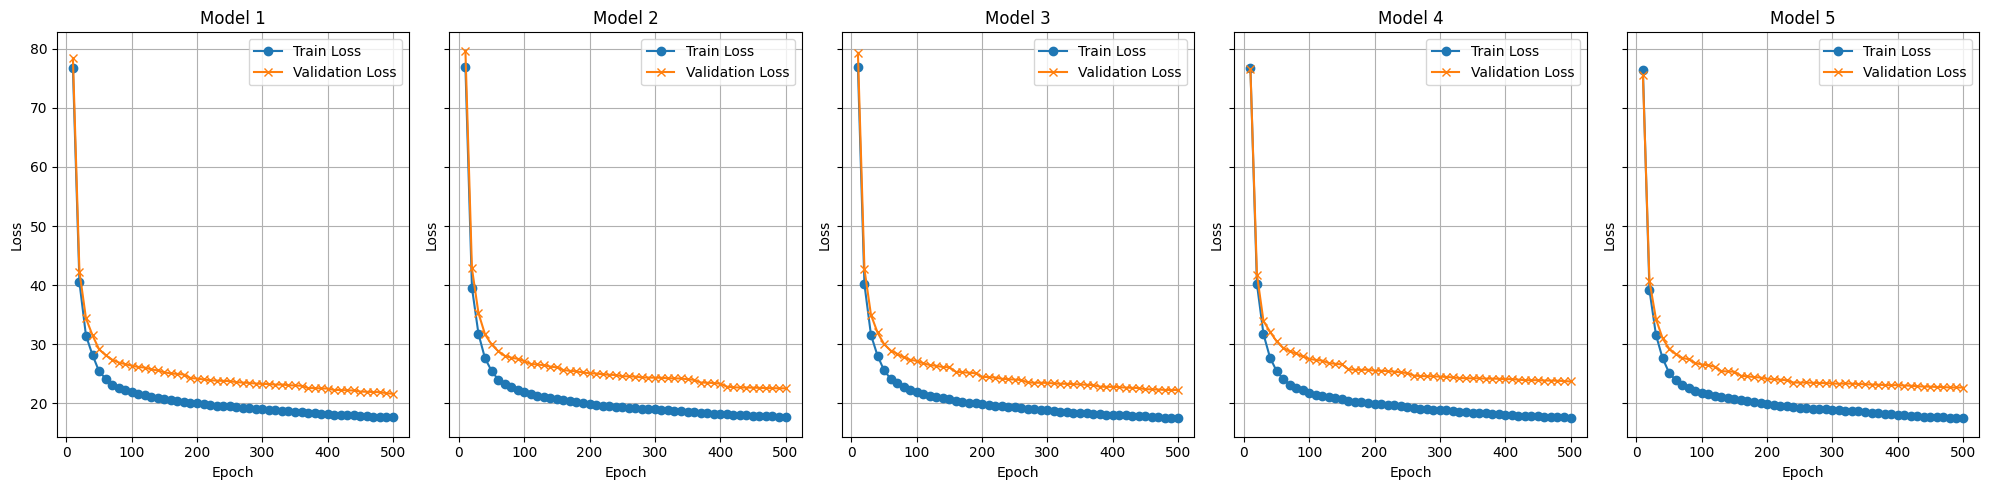

In [93]:
# Plot
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
epochs = np.array(range(1, len(train_losses[0]) + 1))
epochs = epochs*10

for i in range(5):
    ax = axes[i]
    ax.plot(epochs, train_losses[i], label='Train Loss', marker='o')
    ax.plot(epochs, val_losses[i], label='Validation Loss', marker='x')
    ax.set_title(f'Model {i+1}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### 4. Inference model on test data

* Load 5 model trained

In [23]:
model_1 = lgb.Booster(model_file='save_models/model_1.txt')
model_2 = lgb.Booster(model_file='save_models/model_2.txt')
model_3 = lgb.Booster(model_file='save_models/model_3.txt')
model_4 = lgb.Booster(model_file='save_models/model_4.txt')
model_5 = lgb.Booster(model_file='save_models/model_5.txt')

* Get prediction of 5 model


In [25]:
X_test = data_processing(test_df, calendar_df, inventory_df)

In [27]:
y_hat_1 = model_1.predict(X_test, num_iteration=model_1.best_iteration)
y_hat_2 = model_2.predict(X_test, num_iteration=model_2.best_iteration)
y_hat_3 = model_3.predict(X_test, num_iteration=model_3.best_iteration)
y_hat_4 = model_4.predict(X_test, num_iteration=model_4.best_iteration)
y_hat_5 = model_5.predict(X_test, num_iteration=model_5.best_iteration)

In [29]:
y_ensemble = (y_hat_1 + y_hat_2 + y_hat_3 + y_hat_4 + y_hat_5)/5
y_ensemble

array([ 16.30375588,  81.61043863,  91.637088  , ..., 133.88881447,
       511.12962764,  23.72645016])

In [30]:
y_hat_1

array([ 19.08508017,  80.00435464,  99.95146082, ..., 147.57402794,
       590.07554802,  27.77378927])

* Add prediction to soulution file

In [31]:
solution = pd.read_csv(data_root + '/solution.csv')
solution['sales_hat'] = y_hat_1
print(solution.shape)
solution.head()

(47021, 2)


,id,sales_hat
0,1226_2024-06-03,19.085080
1,1226_2024-06-11,80.004355
2,1226_2024-06-13,99.951461
3,1226_2024-06-15,76.050615
4,1226_2024-06-09,19.270207


In [32]:
solution.to_csv('solution_ans_1.csv', index=False)